In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Time and demand settings
timestep = 0.25
T = 60.0
N = int(T / timestep)
D_EV = 36.0
D_ICV = 36.0

# Flow parameters
V = 900.0
W = 450.0
Ka = 0.12
Qa = (Ka * V * W / (V + W)) * timestep

# Battery parameters
omega = 0.33
epsilon = 1.8e-4
Bmax = 0.5
B0 = 0.35

# Budget/cost per length of path
I_budget = 1e6/500

# Network topology
length = {1: 0.0, 2: 900.0, 3: 1800.0, 4: 900.0, 5: 3600.0, 6: 900.0, 7: 0.0}
E = list(length.keys()) # links
E_R = E[0] # source link (it is unique)
E_S = E[-1] # sink link (it is unique)
E_A = E[1:-1] # normal links i.e. no source and no sink
incoming_links = {1: [], 2: [1], 3: [1], 4: [2], 5: [2], 6: [3, 4], 7: [5, 6]}
outgoing_links = {1: [2, 3], 2: [4, 5], 3: [6], 4: [6], 5: [7], 6: [7], 7: []}
paths = {0: [2, 4, 6], 1: [2, 5], 2: [3, 6]}

model = gp.Model()
model.setParam('OutputFlag', 0) # for no prints

M = ["EV", "ICV"] # class of vehicle: Electric or Internal Combustion

x = model.addVars(E_A, vtype=gp.GRB.BINARY, name="x") # = 1 if link a has WCL
y = model.addVars(len(paths), vtype=gp.GRB.BINARY, name="y") # = 1 if path p is feasible for vehicle M
# y does is only for EV models since for ICV all paths are feasible
B = {(a, p): model.addVar(ub=Bmax, name=f"B({a},{p})") for p in paths for a in paths[p]}  # state of energy, bounded with its max capacity

# The following variables are already defined with the constraint of non-negativity of formula 24
n = model.addVars(M, E, range(N+1), lb=0) # number of vehicle M on link 𝑎 at time t
u = model.addVars(M, E, range(N+1), lb=0) # incoming traffic flow of vehicle M to link 𝑎 at time t
v = model.addVars(M, E, range(N+1), lb=0) # outgoing traffic flow of vehicle M to link 𝑎 at time t
f = {} # upstream traffic of vehicle M at link b, coming from downstream traffic at link a
for m in M:
    for a in E:
        for b in incoming_links[a]:
            for i in range(N+1):
                f[m, b, a, i] = model.addVar(lb=0.0, name=f"f[{m},{b},{a},{i}]")
                
# alpha aggregate link-based share factor of vehicle class 𝑚 of formula 14.
# Must be defined as a variable because it depends on u, otherwise it cannot be computed
alpha = model.addVars(E_A, M, lb=0.0, ub=1.0, name="alpha")
for a in E_A:
        model.addConstr(gp.quicksum(alpha[a, m] for m in M) == 1.0, name="alphabase")
        
# Feasibility of path
                    
# Formula 3: budget constraint
model.addConstr(gp.quicksum(length[a] * x[a] for a in E_A) <= I_budget, name="budget")

# State of energy after travelling on link a is no greater than the battery capacity
Big_M = Bmax + omega * (3600 / V) # 3600 is the maximum length for every link observed
for p, link_list in paths.items():
    for idx, a in enumerate(link_list):
        # Formula 4: initial state of energy or previous one
        prevB = B0 if idx == 0 else B[(link_list[idx - 1], p)]
        # Formula 2: state of energy after traversing link 𝑎 on path 𝑝
        charge = omega * length[a] / V
        # where length[a]/V=t0[a] travel time of link a at velocity Va
        consume = epsilon * length[a]
        # Formula 5: B[a,p] == min(Bmax, energy)
        model.addConstr(B[(a, p)] <= Bmax, name="energia1")
        model.addConstr(B[(a, p)] <= prevB - consume + charge * x[a] + Big_M * (1 - y[p]), name="energia2")
        model.addConstr(B[(a, p)] >= prevB - consume + charge * x[a] - Big_M * (1 - y[p]), name="energia3")
        # Formula 6: feasibility of path (if feasible, B[a,p]>=0)
        model.addConstr(Big_M * (y[p]-1) <= B[(a, p)], name="energia4")
        
# Flow capacity
    
# Compute travel time for formula 13, 14, 20, 21
# /timestep so instead of time of travel we have the needed steps for travelling
travelV = {a: int((length[a]/V)/timestep + 1e-9) for a in length}
travelW = {a: int((length[a]/W)/timestep + 1e-9) for a in length}
# Kronecker's delta for EV paths
delta = {(a, p): int(a in paths[p]) for p in paths for a in E_A}

for i in range(N+1):
    for m in M:
        for a in E:
            # Formula 12: conservation of vehicle numbers
            inflow = gp.quicksum(u[m, a, k] for k in range(i+1))
            outflow = gp.quicksum(v[m, a, k] for k in range(i+1))
            model.addConstr(n[m, a, i] - inflow + outflow == 0, name="12")
            if a in E_A: # i.e. no source or sink link
                if i >= travelV[a]: # formula 13: upstream capacity
                    model.addConstr(gp.quicksum(u[m, a, k] for k in range(max(0,i - travelV[a] + 1), i+1)) - n[m, a, i] <= 0, name="13")
                if i >= travelW[a]: # Formula 14: downstream capacity 
                    model.addConstr(n[m, a, i] + gp.quicksum(v[m, a, k] for k in range(max(0,i - travelW[a] + 1), i+1)) <= Ka * length[a] * alpha[a, m], name="14")
                # Formula 19: flow capacity on links
                inflow = gp.quicksum(f[m, b, a, i] for b in incoming_links[a])
                if m == "EV":
                    model.addConstr(inflow <= Qa * gp.quicksum(delta[(a,p)] * y[p] for p in paths), name="19EV")
                else: # Also for upstream traffic of ICV vehicles, where here all paths are feasible
                    model.addConstr(inflow <= Qa * gp.quicksum(delta[(a,p)] for p in paths), name="19ICV")
            if a != E_R: # i.e. no source link
                # Formula 16: flux conservation for incoming vehicles
                model.addConstr(u[m, a, i] - gp.quicksum(f[m, b, a, i] for b in incoming_links[a]) == 0, name="16")
            if a != E_S: # i.e. no sink link
                # Formula 17: flux conservation for outgoing vehicles
                model.addConstr(v[m, a, i] - gp.quicksum(f[m, a, b, i] for b in outgoing_links[a]) == 0, name="17")
                
    # Formula 15: source link constraint is the demand rate of vehicle
    model.addConstr(u["EV", E_R, i] == D_EV, name="15EV")
    model.addConstr(u["ICV", E_R, i] == D_ICV, name="15ICV")
    # Formula 18: sink link constraint i.e. every vehicle has already exited
    model.addConstr(v["EV", E_S, i] == 0, name="18EV")
    model.addConstr(v["ICV", E_S, i] == 0, name="18ICV")
    
# Supply and demand at node
for a in E_A:
    for i in range(N+1):
        # Formula 20 and 22: supply and corresponding entry flow of the link
        inflow_s = gp.quicksum(u[m, a, k] for m in M for k in range(i))
        outflow_s = gp.quicksum(v[m, a, k] for m in M for k in range(i - travelW[a] + 1)) if i > travelW[a] else 0
        supply = Ka * length[a] + outflow_s - inflow_s
        model.addConstr(gp.quicksum(u[m, a, i] for m in M) <= Qa, name="20")
        model.addConstr(gp.quicksum(u[m, a, i] for m in M) <= supply, name="21")
                                
        # Formula 21 and 23: demand and corresponding exit flow of the link
        inflow_d = gp.quicksum(v[m, a, k] for m in M for k in range(i))
        outflow_d = gp.quicksum(u[m, a, k] for m in M for k in range(i - travelV[a] + 1)) if i > travelV[a] else 0
        demand = outflow_d - inflow_d
        model.addConstr(gp.quicksum(v[m, a, i] for m in M) <= Qa, name="22")
        model.addConstr(gp.quicksum(v[m, a, i] for m in M) <= demand, name="23")

## Extra constraints

In [5]:
# Extra constraints

# Over alpha for controlling which links are used depending on y and the maximum flow for each link
for a in E_A:
    # If no feasible path goes in a, then alpha[EV] = 0, thus also EV flows = 0
    model.addConstr(alpha[a, 'EV'] <= gp.quicksum(delta[(a, p)] * y[p] for p in paths), name="alpha3")  

In [6]:
# No EV flow can be on links of not feasible paths
for p in paths:
    for idx, a in enumerate(paths[p]):
        for i in range(N+1):
            for b in incoming_links[a]:
                model.addConstr(f['EV', b, a, i] <= Qa * y[p], name="flowcap")

In [7]:
model.setObjective(gp.quicksum((N - i + 1) * f[(m, b, E_S, i)] for m in M for b in incoming_links[E_S] for i in range(1, N+1)), gp.GRB.MAXIMIZE)
#model.setObjective(gp.quicksum(n[m, a, i] for m in M for a in E[:-1] for i in range(N+1)) * timestep, gp.GRB.MINIMIZE)
model.optimize()
if model.status == GRB.OPTIMAL:
    print(f"Objective value: {model.ObjVal:.2f}\n")

    for a in E_A:
        if x[a].X > 0.5:
            print(f"WCL installed on arc {a} (length = {length[a]})")

    print("\nFeasible EV Paths:")
    for p in paths:
        if y[p].X > 0.5:
            print(f"Path {p}: {paths[p]}")

else:
    print(f"Model did not solve to optimality. Status: {model.status}")

Objective value: 453744.00

WCL installed on arc 6 (length = 900.0)

Feasible EV Paths:
Path 0: [2, 4, 6]
Path 2: [3, 6]


## Some checks

In [5]:
# See which constraint are violated and with which value
for c in model.getConstrs():
    if c.Slack < -1e-6:
        print(f"⚠️ Constraint {c.ConstrName} violated with slack = {c.Slack:.6f}")

⚠️ Constraint energia3 violated with slack = -1.632000
⚠️ Constraint energia3 violated with slack = -2.468000


In [6]:
# For a specific constraint
constr = model.getConstrByName(f"15ICV") # <- insert name of constraint
print(f"Slack: {constr.Slack:.4f}")

Slack: 0.0000


In [7]:
# See fraction and percentage of slackness
from collections import defaultdict

families = defaultdict(list)

for c in model.getConstrs():
    name = c.ConstrName
    slack = c.Slack
    if name:  # neglect anonymous constraints
        family = name.split("_")[0]
        families[family].append(abs(slack))
        
for fam, slacks in families.items():
    n_tight = sum(1 for s in slacks if s < 1e-6)
    print(f"{fam}: {n_tight}/{len(slacks)} tight ({100 * n_tight / len(slacks):.1f}%)")

alphabase: 1200/1200 tight (100.0%)
budget: 0/1 tight (0.0%)
energia1: 0/7 tight (0.0%)
energia2: 5/7 tight (71.4%)
energia3: 5/7 tight (71.4%)
energia4: 0/7 tight (0.0%)
12: 3374/3374 tight (100.0%)
17: 2892/2892 tight (100.0%)
19EV: 283/1205 tight (23.5%)
16: 2892/2892 tight (100.0%)
19ICV: 406/1205 tight (33.7%)
15EV: 241/241 tight (100.0%)
15ICV: 241/241 tight (100.0%)
18EV: 241/241 tight (100.0%)
18ICV: 241/241 tight (100.0%)
13: 2300/2338 tight (98.4%)
14: 1932/2266 tight (85.3%)
20: 898/1205 tight (74.5%)
21: 799/1205 tight (66.3%)
22: 898/1205 tight (74.5%)
23: 1169/1205 tight (97.0%)
alpha3: 240/1200 tight (20.0%)
flowcap: 608/2169 tight (28.0%)


In [8]:
# See also their mean and standard deviation
slacks_by_family = defaultdict(list)

for c in model.getConstrs():
    if c.ConstrName:
        family = c.ConstrName.split("_")[0]
        slacks_by_family[family].append(abs(c.Slack))

for fam, slacks in slacks_by_family.items():
    arr = np.array(slacks)
    print(f"{fam}: avg slack = {arr.mean():.4f}, std = {arr.std():.4f}, min = {arr.min():.4f}")

alphabase: avg slack = 0.0000, std = 0.0000, min = 0.0000
budget: avg slack = 1100.0000, std = 0.0000, min = 1100.0000
energia1: avg slack = 0.4103, std = 0.0891, min = 0.3060
energia2: avg slack = 0.4543, std = 0.7522, min = 0.0000
energia3: avg slack = 0.5857, std = 0.9527, min = 0.0000
energia4: avg slack = 0.6097, std = 0.7685, min = 0.0260
12: avg slack = 0.0000, std = 0.0000, min = 0.0000
17: avg slack = 0.0000, std = 0.0000, min = 0.0000
19EV: avg slack = 8.3726, std = 5.6574, min = 0.0000
16: avg slack = 0.0000, std = 0.0000, min = 0.0000
19ICV: avg slack = 6.5203, std = 5.1105, min = 0.0000
15EV: avg slack = 0.0000, std = 0.0000, min = 0.0000
15ICV: avg slack = 0.0000, std = 0.0000, min = 0.0000
18EV: avg slack = 0.0000, std = 0.0000, min = 0.0000
18ICV: avg slack = 0.0000, std = 0.0000, min = 0.0000
13: avg slack = 0.1463, std = 1.1380, min = 0.0000
14: avg slack = 13.9131, std = 35.5281, min = 0.0000
20: avg slack = 2.2929, std = 3.9216, min = 0.0000
21: avg slack = 38.5469,

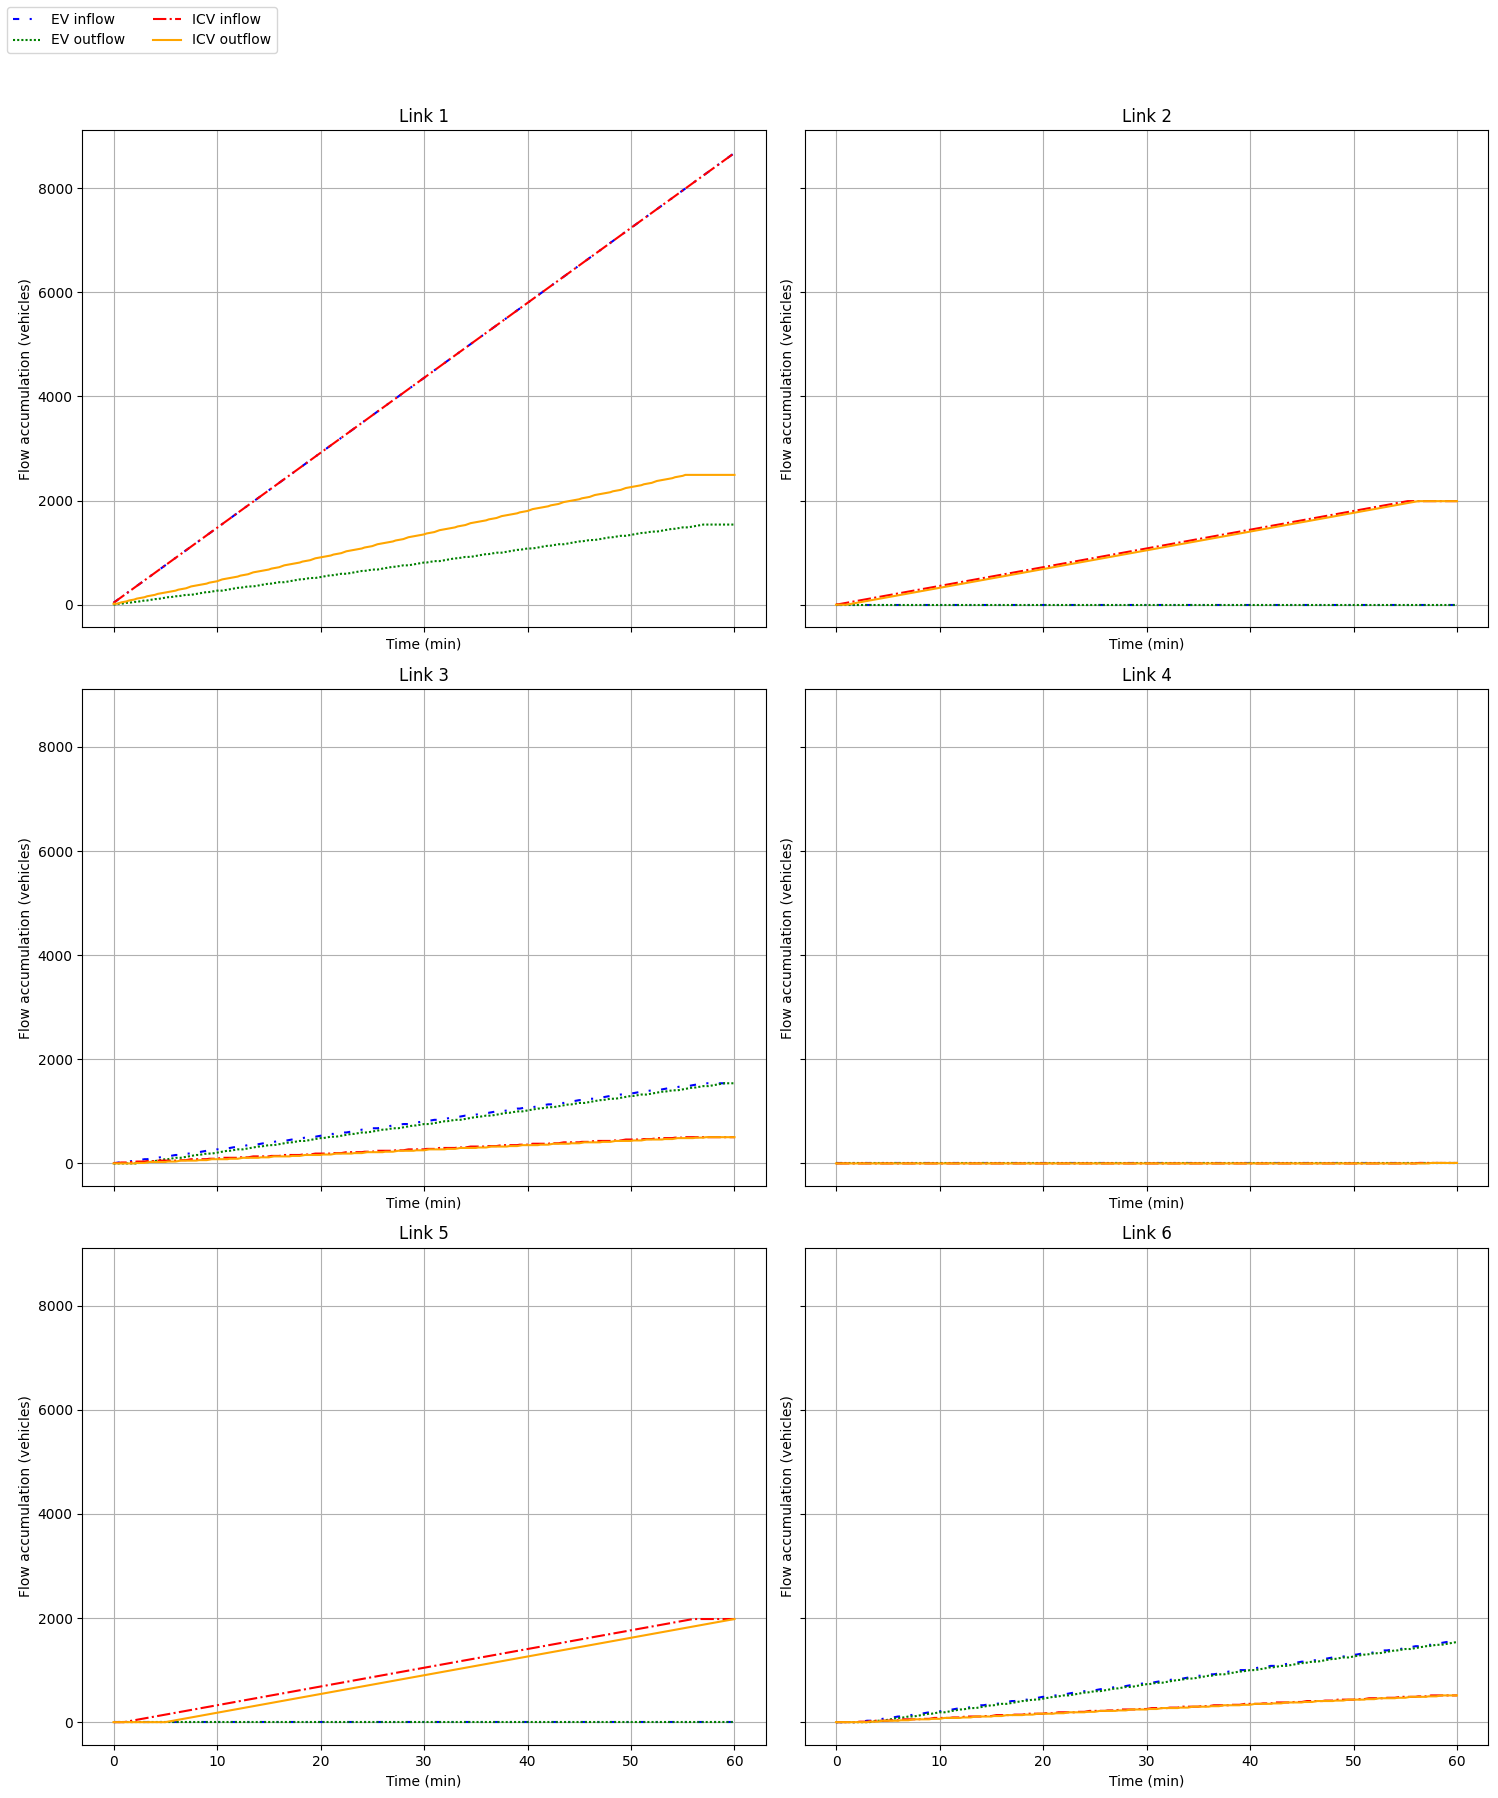

In [8]:
# Plot as figure 3 of the paper
x_time = [i * timestep for i in range(N+1)]

#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18), sharex=True, sharey=True)
axes = axes.flatten()

for idx, a in enumerate(E[:-1]):
    ax = axes[idx]

    EV_inflow = [(u["EV", a, i].X ) for i in range(N+1)]
    EV_outflow = [(v["EV", a, i].X ) for i in range(N+1)]
    ICV_inflow = [(u["ICV", a, i].X ) for i in range(N+1)]
    ICV_outflow = [(v["ICV", a, i].X ) for i in range(N+1)]

    ax.plot(x_time, np.cumsum(EV_inflow), label="EV inflow", linestyle=(0,(3,5,1,5)), color='blue')
    ax.plot(x_time, np.cumsum(EV_outflow), label="EV outflow", linestyle=(0,(1,1)), color='green')
    ax.plot(x_time, np.cumsum(ICV_inflow), label="ICV inflow", linestyle='dashdot', color='red')
    ax.plot(x_time, np.cumsum(ICV_outflow), label="ICV outflow", linestyle='solid', color='orange')

    ax.set_title(f"Link {a}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Flow accumulation (vehicles)")
    ax.grid(True)

# A common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='upper left')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [10]:
if model.status == GRB.OPTIMAL:
    print("Congestion analysis:")
    for a in E[:-1]:
        total_flow = sum(f['EV',b,a,i].X + f['ICV',b,a,i].X for b in incoming_links[a] for i in range(N+1))
        capacity = Qa * timestep * N
        print(f"Link {a}: Flow={total_flow:.1f}, Capacity={capacity:.1f}, Utilization={total_flow/capacity:.1%}")
        if total_flow > capacity:
            print(f"  ⚠️ Congestion found!")

Congestion analysis:
Link 1: Flow=0.0, Capacity=540.0, Utilization=0.0%
Link 2: Flow=1998.0, Capacity=540.0, Utilization=370.0%
  ⚠️ Congestion found!
Link 3: Flow=2034.0, Capacity=540.0, Utilization=376.7%
  ⚠️ Congestion found!
Link 4: Flow=18.0, Capacity=540.0, Utilization=3.3%
Link 5: Flow=1980.0, Capacity=540.0, Utilization=366.7%
  ⚠️ Congestion found!
Link 6: Flow=2052.0, Capacity=540.0, Utilization=380.0%
  ⚠️ Congestion found!


In [11]:
total_travel_time = 0.0
for m in M:
    for a in E:
        for i in range(N+1):
            total_travel_time += n[m, a, i].X * timestep

print(f"Total Travel Time (EV + ICV): {total_travel_time:.2f} vehicle-minutes")

Total Travel Time (EV + ICV): 524898.00 vehicle-minutes


In [12]:
print("MAX OCCUPATION IN LINKS")
for a in E_A:
    max_n = max(n[m, a, i].X for m in M for i in range(N+1))
    capacity = Ka * length[a]
    print(f"Link {a}: Max n = {max_n:.2f} vs Capacity = {capacity:.2f} ({(max_n / capacity) * 100:.1f}%)")

MAX OCCUPATION IN LINKS
Link 2: Max n = 45.00 vs Capacity = 108.00 (41.7%)
Link 3: Max n = 81.00 vs Capacity = 216.00 (37.5%)
Link 4: Max n = 18.00 vs Capacity = 108.00 (16.7%)
Link 5: Max n = 144.00 vs Capacity = 432.00 (33.3%)
Link 6: Max n = 36.00 vs Capacity = 108.00 (33.3%)
